In [1]:
!wget https://github.com/karoldvl/ESC-50/archive/master.zip
!unzip master.zip

--2025-07-26 20:25:42--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2025-07-26 20:25:42--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2025-07-26 20:25:42--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip            

In [2]:
import os
import pandas as pd
import numpy as np
import librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

ESC50_PATH = 'ESC-50-master'
AUDIO_PATH = os.path.join(ESC50_PATH, 'audio')
CSV_PATH = os.path.join(ESC50_PATH, 'meta', 'esc50.csv')

df = pd.read_csv(CSV_PATH)

le = LabelEncoder()
df['target'] = le.fit_transform(df['category'])

class_names = list(le.classes_)

SAMPLE_RATE = 22050
DURATION = 5
SAMPLES_PER_CLIP = SAMPLE_RATE * DURATION
N_MELS = 128
SPEC_WIDTH = 431

def audio_to_mel(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    if len(y) < SAMPLES_PER_CLIP:
        y = np.pad(y, (0, SAMPLES_PER_CLIP - len(y)))
    else:
        y = y[:SAMPLES_PER_CLIP]
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db = mel_db / 255.0
    if mel_db.shape[1] < SPEC_WIDTH:
        mel_db = np.pad(mel_db, ((0, 0), (0, SPEC_WIDTH - mel_db.shape[1])))
    else:
        mel_db = mel_db[:, :SPEC_WIDTH]
    return mel_db

X = []
y = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    file_path = os.path.join(AUDIO_PATH, row['filename'])
    mel_spec = audio_to_mel(file_path)
    X.append(mel_spec)
    y.append(row['target'])

X = np.array(X)[..., np.newaxis]
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.1, random_state=42)

import tensorflow_addons as tfa

data_gen = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(height_factor=0.1),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomContrast(0.2),
])

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


100%|██████████| 2000/2000 [00:46<00:00, 43.28it/s]


Train: (1440, 128, 431, 1)
Val: (160, 128, 431, 1)
Test: (400, 128, 431, 1)


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (128, 431, 1)
num_classes = 50

def make_esc50_model():
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = make_esc50_model()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 429, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 429, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 214, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 214, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 212, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 212, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 106, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 106, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 104, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 104, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 50, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 25, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 25, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,830,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,234,290 (39.04 MB)

 Trainable params: 10,232,818 (39.04 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [4]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.0376 - loss: 4.4912 - val_accuracy: 0.0188 - val_loss: 7.7179 - learning_rate: 5.0000e-04
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.1145 - loss: 3.5114 - val_accuracy: 0.0188 - val_loss: 8.4616 - learning_rate: 5.0000e-04
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.1835 - loss: 3.1400 - val_accuracy: 0.0188 - val_loss: 9.7071 - learning_rate: 5.0000e-04
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.2759 - loss: 2.5956 - val_accuracy: 0.0188 - val_loss: 11.0773 - learning_rate: 5.0000e-04
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.3965 - loss: 2.2057 - val_accuracy: 0.0188 - val_loss: 9.4750 - learning_rate: 2.5000e-04
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.4755 - loss: 1.9209 - val_accuracy: 0.0250 - val_loss: 9.8465 - learning_rate: 2.5000e-04
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accurac

The accuracy and val accuracy is too off. The model is likely overfitting.

In [5]:
import tensorflow as tf

BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.GaussianNoise(0.01),
])

def create_dataset(X, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(1024).map(lambda x, y: (data_augment(x), y), num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = create_dataset(X_train, y_train, training=True)
val_ds = create_dataset(X_val, y_val)
test_ds = create_dataset(X_test, y_test)


In [6]:
from tensorflow.keras import layers, models, regularizers

def make_best_esc50_model(input_shape=(128, 431, 1), num_classes=50):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = make_best_esc50_model()
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 431, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 431, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 215, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 215, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 215, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 215, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 107, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 107, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 107, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 107, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 53, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 53, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 53, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 53, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 26, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 26, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │         6,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,618 (1.64 MB)

 Trainable params: 428,402 (1.63 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [7]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    callbacks=callbacks
)


Epoch 1/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 213ms/step - accuracy: 0.0268 - loss: 4.9310 - val_accuracy: 0.0188 - val_loss: 4.2654 - learning_rate: 1.0000e-04
Epoch 2/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.0216 - loss: 4.7763 - val_accuracy: 0.0188 - val_loss: 4.3754 - learning_rate: 1.0000e-04
Epoch 3/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.0299 - loss: 4.7047 - val_accuracy: 0.0188 - val_loss: 4.5434 - learning_rate: 1.0000e-04
Epoch 4/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.0244 - loss: 4.7359 - val_accuracy: 0.0188 - val_loss: 4.7504 - learning_rate: 1.0000e-04
Epoch 5/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.0244 - loss: 4.7107 - val_accuracy: 0.0188 - val_loss: 5.1760 - learning_rate: 1.0000e-04
Epoch 6/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.0154 - loss: 4.7147 - val_accuracy: 0.0188 - val_loss: 5.7647 - learning_rate: 5.0000e-05
Epoch 7/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accurac

KeyboardInterrupt: 

The model is now too simple. Lets try using transfer learning by using the yamnet model as a base.

In [8]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import librosa

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

def extract_yamnet_embedding(waveform, sr=16000):
    waveform = librosa.resample(waveform, orig_sr=sr, target_sr=16000)
    waveform = waveform[:16000 * 5]
    waveform = waveform.astype(np.float32)

    scores, embeddings, spectrogram = yamnet_model(waveform)

    return tf.reduce_mean(embeddings, axis=0).numpy()


In [11]:
import pandas as pd
import os

ESC50_PATH = 'ESC-50-master'
CSV_PATH = os.path.join(ESC50_PATH, 'meta', 'esc50.csv')
AUDIO_PATH = os.path.join(ESC50_PATH, 'audio')

df = pd.read_csv(CSV_PATH)

train_df = df[df['fold'] != 5]
test_df  = df[df['fold'] == 5]

file_paths_train = [os.path.join(AUDIO_PATH, fname) for fname in train_df['filename']]
class_ids_train = train_df['target'].tolist()

file_paths_test = [os.path.join(AUDIO_PATH, fname) for fname in test_df['filename']]
class_ids_test = test_df['target'].tolist()


In [13]:
import os
from tqdm import tqdm

X = []
y = []

for file_path, label in tqdm(zip(file_paths_train, class_ids_train)):
    waveform, sr = librosa.load(file_path, sr=None)
    embedding = extract_yamnet_embedding(waveform, sr)
    X.append(embedding)
    y.append(label)

X = np.array(X)
y = np.array(y)


1600it [00:16, 96.79it/s] 


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [19]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(1024,)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(50, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=32)


Epoch 1/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.0984 - loss: 3.9423 - val_accuracy: 0.5063 - val_loss: 2.5803
Epoch 2/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4146 - loss: 2.5546 - val_accuracy: 0.6187 - val_loss: 1.5836
Epoch 3/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5549 - loss: 1.8496 - val_accuracy: 0.6750 - val_loss: 1.2972
Epoch 4/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6005 - loss: 1.5211 - val_accuracy: 0.7031 - val_loss: 1.1689
Epoch 5/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6526 - loss: 1.3781 - val_accuracy: 0.7281 - val_loss: 1.0731
Epoch 6/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6759 - loss: 1.2667 - val_accuracy: 0.7125 - val_loss: 1.0180
Epoch 7/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6758 - loss: 1.2014 - val_accuracy: 0.7344 - val_loss: 1.0031
Epoch 8/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6958 - loss: 1.1709 - val_accuracy: 0.7469 - 

In [ ]:
from tqdm import tqdm
import librosa
import numpy as np

X_test = []
y_test = []

for file_path, label in tqdm(zip(file_paths_test, class_ids_test), total=len(file_paths_test)):
    waveform, sr = librosa.load(file_path, sr=None)
    embedding = extract_yamnet_embedding(waveform, sr)
    X_test.append(embedding)
    y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

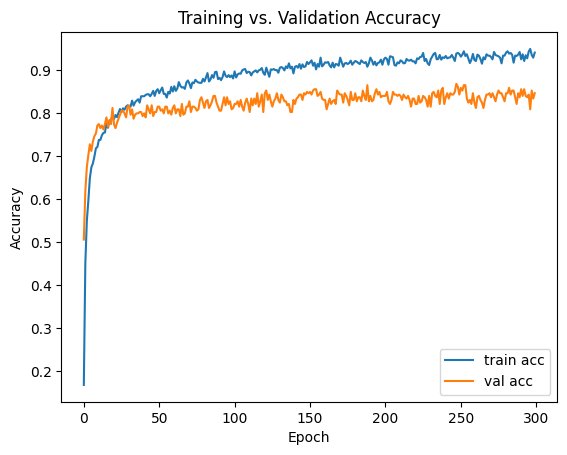

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


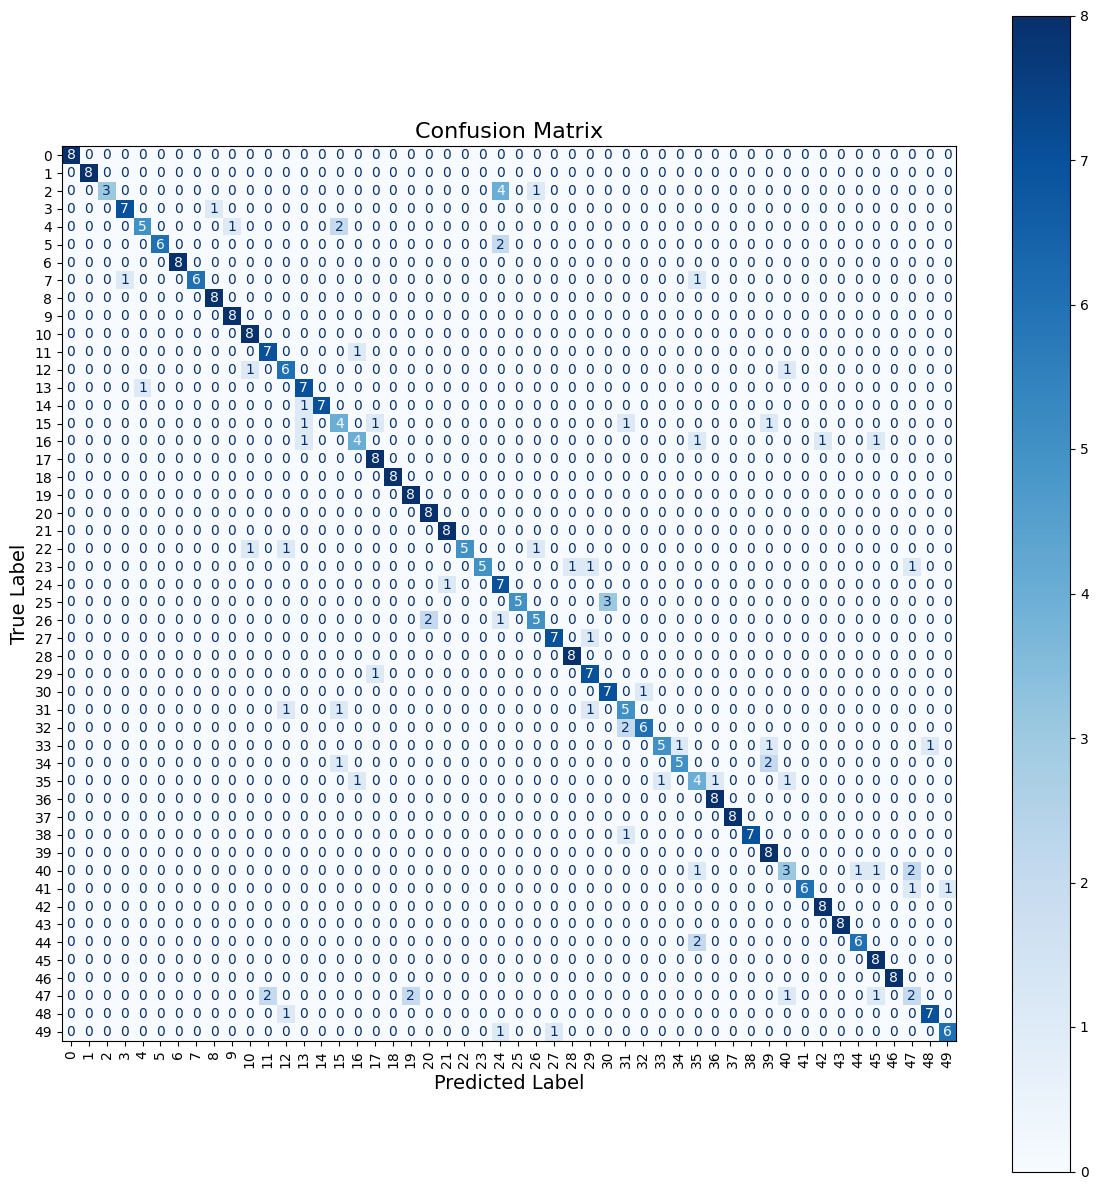

              precision    recall  f1-score   support

           0      1.000     1.000     1.000         8
           1      1.000     1.000     1.000         8
           2      1.000     0.375     0.545         8
           3      0.875     0.875     0.875         8
           4      0.833     0.625     0.714         8
           5      1.000     0.750     0.857         8
           6      1.000     1.000     1.000         8
           7      1.000     0.750     0.857         8
           8      0.889     1.000     0.941         8
           9      0.889     1.000     0.941         8
          10      0.800     1.000     0.889         8
          11      0.778     0.875     0.824         8
          12      0.667     0.750     0.706         8
          13      0.700     0.875     0.778         8
          14      1.000     0.875     0.933         8
          15      0.500     0.500     0.500         8
          16      0.667     0.500     0.571         8
          17      0.800    

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.show()


y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

fig, ax = plt.subplots(figsize=(12, 12))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")

plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.tight_layout()
plt.show()

report = classification_report(y_test, y_pred, digits=3)
print(report)

In [27]:
model.save("/content/audio-classifier.keras")